In [1]:
# --- STEP 1: Upload all required Excel and PRS loci files in one go ---
from google.colab import files
import pandas as pd
import io
import re

# Prompt user once for all uploads
print("📂 Please select the following files together:")
print("  • 271_training_cohort_4_new_PRS_cleaned.xlsx")
print("  • 1013_testing_cohort_pure_suspects.xlsx")
print("  • 1088_testing_cohort_including_1013_suspects.xlsx")
print("  • MTAG_PRS_526_loci.txt")
print("  • MEGA_PRS_616_loci.txt\n")

uploaded = files.upload()

# --- Identify files by name pattern ---
train_key  = next((k for k in uploaded if re.search(r"271[_-]?training", k, re.I)), None)
test1013_key = next((k for k in uploaded if re.search(r"1013[_-]?testing", k, re.I)), None)
test1088_key = next((k for k in uploaded if re.search(r"1088[_-]?testing", k, re.I)), None)
mtag_key   = next((k for k in uploaded if re.search(r"MTAG[_-]?PRS[_-]?526[_-]?loci", k, re.I)), None)
mega_key   = next((k for k in uploaded if re.search(r"MEGA[_-]?PRS[_-]?(616|526)[_-]?loci", k, re.I)), None)

assert train_key and test1013_key and test1088_key and mtag_key and mega_key, \
    "❌ Missing one or more required files. Please upload all 5."

# --- Load Excel files ---
train_df    = pd.read_excel(io.BytesIO(uploaded[train_key]))
test_1013_df = pd.read_excel(io.BytesIO(uploaded[test1013_key]))
test_1088_df = pd.read_excel(io.BytesIO(uploaded[test1088_key]))

# --- Helper to read loci (whitespace-delimited) ---
def read_loci(buf):
    df = pd.read_csv(io.BytesIO(buf), sep=r"\s+", engine="python")
    df.columns = [c.strip().upper() for c in df.columns]
    assert "SNP" in df.columns and "BETA" in df.columns, "Expected columns 'SNP' and 'BETA'."
    return df[["SNP", "BETA"]].copy()

mtag_df = read_loci(uploaded[mtag_key])
mega_df = read_loci(uploaded[mega_key])

# --- Confirmation summary ---
print("✅ Files loaded successfully:")
print(f"  Training cohort: {train_key}  ({train_df.shape[0]} rows)")
print(f"  Testing (1013 suspects): {test1013_key}  ({test_1013_df.shape[0]} rows)")
print(f"  Testing (1088 incl. 1013): {test1088_key}  ({test_1088_df.shape[0]} rows)")
print(f"  PRS526 loci: {mtag_key}  ({len(mtag_df)} rows)")
print(f"  PRS616 loci: {mega_key}  ({len(mega_df)} rows)")


📂 Please select the following files together:
  • 271_training_cohort_4_new_PRS_cleaned.xlsx
  • 1013_testing_cohort_pure_suspects.xlsx
  • 1088_testing_cohort_including_1013_suspects.xlsx
  • MTAG_PRS_526_loci.txt
  • MEGA_PRS_616_loci.txt



Saving 1088_testing_cohort_including_1013_suspects.xlsx to 1088_testing_cohort_including_1013_suspects (5).xlsx
Saving 1013_testing_cohort_pure_suspects.xlsx to 1013_testing_cohort_pure_suspects (5).xlsx
Saving 271_training_cohort_4_new_PRS_cleaned.xlsx to 271_training_cohort_4_new_PRS_cleaned (5).xlsx
Saving MTAG_PRS_526_loci.txt to MTAG_PRS_526_loci (5).txt
Saving MEGA_PRS_616_loci.txt to MEGA_PRS_616_loci (5).txt
✅ Files loaded successfully:
  Training cohort: 271_training_cohort_4_new_PRS_cleaned (5).xlsx  (271 rows)
  Testing (1013 suspects): 1013_testing_cohort_pure_suspects (5).xlsx  (1013 rows)
  Testing (1088 incl. 1013): 1088_testing_cohort_including_1013_suspects (5).xlsx  (1088 rows)
  PRS526 loci: MTAG_PRS_526_loci (5).txt  (526 rows)
  PRS616 loci: MEGA_PRS_616_loci (5).txt  (616 rows)


In [2]:
# STEP 1: Upload your clean cohort Excel file
#done in previous cell

import pandas as pd
import numpy as np

# Load the Excel file
# Assign for consistency with old variable names
df = train_df.copy()

# Define feature sets
# Define feature sets (updated for new PRS variables)
feature_sets = {
    "Age": ['Age'],
    "Gender": ['Gender'],
    "base": ['Age', 'Gender'],

    # Replace GRS 1–4 with PRS-CS and MTAG/MEGA variants
    "POAAGG PRS": ['POAAGG PRS'],
    "MEGA PRS": ['MEGA PRS'],
    "PRS526": ['PRS526'],
    "PRS616": ['PRS616'],

    # Combined PRS sets
    "PRS": ['POAAGG PRS', 'MEGA PRS', 'PRS526', 'PRS616'],

    # Base + individual PRS
    "base+POAAGG PRS": ['Age', 'Gender', 'POAAGG PRS'],
    "base+MEGA PRS": ['Age', 'Gender', 'MEGA PRS'],
    "base+PRS526": ['Age', 'Gender', 'PRS526'],
    "base+PRS616": ['Age', 'Gender', 'PRS616'],

    # Base + combined PRS
    "base+PRS": ['Age', 'Gender', 'POAAGG PRS', 'MEGA PRS', 'PRS526', 'PRS616'],

    # All-inclusive feature set
    "all": ['Age', 'Gender', 'POAAGG PRS', 'MEGA PRS', 'PRS526', 'PRS616']
}


# Set the binary label
df = df.dropna(subset=['CaseCtrl'])
df['CaseCtrl'] = df['CaseCtrl'].astype(int)


In [3]:
[c for c in df.columns if "PRS" in c or "POAAGG" in c or "MEGA" in c or "MTAG" in c]


['POAAGG ID',
 'POAAGG PRS',
 'MEGA PRS',
 'PRS526',
 'PRS616',
 'mediated IOP PRS',
 'medaited CDR PRS',
 'mediated RNFL PRS']

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression


# Define models
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=300,                 # a few more trees → smoother, stabler AUC
        max_depth=5,                      # allow a bit more structure (was 3)
        min_samples_split=20,             # loosen split constraint (was 50)
        min_samples_leaf=10,              # smaller leaves, still regularized (was 25)
        max_features=1.0,                 # consider all features (or "sqrt" if >10 features)
        bootstrap=True,
        class_weight="balanced_subsample",
        ccp_alpha=0.001,                  # lighter post-pruning (was 0.005)
        random_state=42
    ),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        alpha=1e-3,                   # stronger L2 for bigger net
        learning_rate_init=1e-3,
        batch_size=32,
        max_iter=2000,
        early_stopping=True,
        n_iter_no_change=50,
        validation_fraction=0.20,
        random_state=42
    ),

    "SVM": SVC(
        kernel="rbf",
        C=4.0,                        # looser regularization → sharper boundary
        gamma=2.0,                    # more localized kernel
        class_weight="balanced",
        probability=True,
        tol=1e-4,
        cache_size=1000,
        random_state=42
    ),
    "Logistic Regression": LogisticRegression(
        solver="liblinear",           # robust for small datasets
        penalty="l2",                 # standard L2 regularization
        C=1.0,                        # inverse regularization strength
        class_weight="balanced",      # adjusts for class imbalance
        max_iter=1000,
        random_state=42
    )
}



# Bootstrap and evaluate
results = []
n_bootstraps = 10

for fs_name, features in feature_sets.items():
    X = df[features]
    y = df['CaseCtrl']

    for model_name, model in models.items():
        metrics = {
            "Accuracy": [], "F1": [], "AUC": [],
            "Sensitivity": [], "Specificity": []
        }

        for _ in range(n_bootstraps):
            X_resample, y_resample = resample(X, y, stratify=y)
            pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler()),
                ('clf', model)
            ])
            X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.2)
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            y_prob = pipeline.predict_proba(X_test)[:, 1]

            report = classification_report(y_test, y_pred, output_dict=True)
            metrics['Accuracy'].append(report['accuracy'])
            metrics['F1'].append(report['1']['f1-score'])
            metrics['Sensitivity'].append(report['1']['recall'])
            metrics['Specificity'].append(report['0']['recall'])
            metrics['AUC'].append(roc_auc_score(y_test, y_prob))

        for metric, values in metrics.items():
            mean = np.mean(values)
            std = np.std(values)
            ci = 1.96 * (std / np.sqrt(len(values)))
            results.append({
                "Feature Set": fs_name,
                "Model": model_name,
                "Metric": metric,
                "Mean": round(mean, 3),
                "95% CI": f"{round(mean, 3)} ± {round(ci, 3)}"
            })

# Save results
results_df = pd.DataFrame(results)
results_df.to_excel("clean_cohort_model_results.xlsx", index=False)
files.download("clean_cohort_model_results.xlsx")


import seaborn as sns
import matplotlib.pyplot as plt

# Pivot data for plotting
sns.set(style="whitegrid")
#metrics_to_plot = ['Accuracy', 'F1', 'AUC', 'Sensitivity', 'Specificity']
metrics_to_plot = ['AUC']
filenames = []

for metric in metrics_to_plot:
    plot_df = results_df[results_df["Metric"] == metric]
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=plot_df,
        x="Feature Set",
        y="Mean",
        hue="Model",
        width=0.6
    )
    plt.title(f"{metric} Across Models and Feature Sets")
    plt.ylabel(metric)
    plt.xlabel("Feature Set")
    plt.xticks(rotation=30, ha='right')
    plt.ylim(0, 1.3)
    plt.legend(title="Model", loc='upper right')
    plt.tight_layout()
    fname = f"{metric}_CleanCohort.png"
    plt.savefig(fname, dpi=300)
    filenames.append(fname)
    plt.close()

# Download all plots
for f in filenames:
    files.download(f)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from google.colab import files

# choose feature set
target_feature_sets = ["all"]

for fs_name in target_feature_sets:
    features = feature_sets[fs_name]
    X = df[features]
    y = df['CaseCtrl']

    # Train Random Forest
    rf = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    rf.fit(X, y)

    # Get feature importances
    importances = rf.named_steps['rf'].feature_importances_
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # ✅ Save feature importances to Excel
    excel_name = f"Feature_Importance_{fs_name.replace('+','_')}.xlsx"
    importance_df.to_excel(excel_name, index=False)
    files.download(excel_name)

    # ✅ Plot with numeric values next to bars
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')

    # Annotate values next to bars
    for i, (imp, feat) in enumerate(zip(importance_df['Importance'], importance_df['Feature'])):
        ax.text(imp + 0.01, i, f"{imp:.3f}", va='center', ha='left', fontsize=9, fontweight='bold')

    plt.title(f'Random Forest Feature Importance ({fs_name})')
    plt.xlabel("Feature Importance")
    plt.tight_layout()

    fig_name = f"Feature_Importance_{fs_name.replace('+','_')}.png"
    plt.savefig(fig_name, dpi=300, bbox_inches='tight')
    files.download(fig_name)
    plt.close()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-3463204739.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# STEP 4: External Testing on 1088 Cohort (Full Metrics for ALL Feature Sets)

import pandas as pd
import numpy as np
from sklearn.metrics import (
    roc_auc_score, accuracy_score, recall_score, f1_score, confusion_matrix
)

# Assign for consistency with previous variable names
test_df = test_1088_df.copy()

# 1. Define label groups
test_df['Disease status'] = test_df['Disease status'].astype(str)
test_cases = test_df[test_df['Disease status'].str.contains("Case", case=False, na=False)]
test_controls = test_df[test_df['Disease status'].str.contains("Control", case=False, na=False)]
test_suspects = test_df[test_df['Disease status'].str.contains("Suspect", case=False, na=False)]

# 2. Initialize results container
external_results = []

# 3. Loop through all feature sets and models
for fs_name, features in feature_sets.items():
    # Skip if features are missing in test_df (avoid KeyErrors)
    if not set(features).issubset(test_df.columns):
        print(f"⚠️ Skipping {fs_name} (missing features in test cohort)")
        continue

    # Define training and test data
    X_train = df[features]
    y_train = df['CaseCtrl']
    X_test_casecontrol = pd.concat([test_cases, test_controls])
    y_test = X_test_casecontrol['Disease status'].apply(lambda x: 1 if 'Case' in x else 0)
    X_test = X_test_casecontrol[features].replace([np.inf, -np.inf], np.nan)

    for model_name, model in models.items():
        # Preprocess pipeline
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('clf', model)
        ])

        # Train and predict
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]

        # Compute metrics
        auc = roc_auc_score(y_test, y_prob)
        acc = accuracy_score(y_test, y_pred)
        sens = recall_score(y_test, y_pred, pos_label=1)
        spec = recall_score(y_test, y_pred, pos_label=0)
        f1 = f1_score(y_test, y_pred)

        external_results.append({
            'Feature Set': fs_name,
            'Model': model_name,
            'Test AUC': round(auc, 3),
            'Accuracy': round(acc, 3),
            'Sensitivity': round(sens, 3),
            'Specificity': round(spec, 3),
            'F1-score': round(f1, 3)
        })

# 4. Convert results to DataFrame and save
external_df = pd.DataFrame(external_results)
display(external_df)

output_filename = "external_test_metrics_results.xlsx"
external_df.to_excel(output_filename, index=False)
files.download(output_filename)


,Feature Set,Model,Test AUC,Accuracy,Sensitivity,Specificity,F1-score
0,Age,Random Forest,0.594,0.587,0.516,0.636,0.508
1,Age,MLP,0.575,0.587,0.613,0.568,0.551
2,Age,SVM,0.536,0.587,0.581,0.591,0.537
3,Age,Logistic Regression,0.576,0.600,0.645,0.568,0.571
4,Gender,Random Forest,0.526,0.533,0.484,0.568,0.462
5,Gender,MLP,0.510,0.533,0.484,0.568,0.462
6,Gender,SVM,0.526,0.533,0.484,0.568,0.462
7,Gender,Logistic Regression,0.526,0.533,0.484,0.568,0.462
8,base,Random Forest,0.606,0.547,0.645,0.477,0.541
9,base,MLP,0.598,0.547,0.516,0.568,0.485


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import numpy as np

# Create dataframe to collect correlation results
correlation_records = []

# We'll collect risk predictions for all models here
risk_export_df = test_suspects.copy()

# Define models and feature set
chosen_fs = "base+PRS616"
chosen_features = feature_sets[chosen_fs]

# ✅ Use your exact column names here:
clinical_markers = {
    "IOP_max": "IOP_SEVERE",
    "CDR_max": "CDR_SEVERE",
    "RNFL_min": "RNFL_SEVERE"
}

# Define custom y-axis limits for each marker
y_axis_limits = {
    "IOP_SEVERE": (10, 30),
    "CDR_SEVERE": (0.4, 0.8),
    "RNFL_SEVERE": (70, 105)
}

# Loop over models
for model_name, model in models.items():
    print(f"Processing model: {model_name}")

    # Train on full clean cohort
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    pipeline.fit(df[chosen_features], df["CaseCtrl"])

    # Predict for suspects
    suspect_risks = pipeline.predict_proba(test_suspects[chosen_features])[:, 1]
    risk_col = f"{model_name}_Risk"
    risk_export_df[risk_col] = suspect_risks  # <-- Collect risk scores

    test_suspects_copy = test_suspects.copy()
    test_suspects_copy[risk_col] = suspect_risks

    # Loop over markers and generate plots
    for marker_col, marker_label in clinical_markers.items():
        if marker_label not in test_suspects_copy.columns:
            print(f"❌ Missing column: {marker_label}, skipping...")
            continue

        # Ensure numeric & drop NaNs
        valid_data = test_suspects_copy[[risk_col, marker_label]].copy()
        valid_data = valid_data.dropna()
        x = valid_data[risk_col].astype(float)
        y = valid_data[marker_label].astype(float)

        print(f"✅ Correlation: {model_name} vs {marker_label} ({len(valid_data)} rows)")

        if len(valid_data) < 10:
            print(f"⚠️ Too few data points to compute correlation: {marker_label}")
            continue

        # Compute correlations
        pearson_r, pearson_p = pearsonr(x, y)
        spearman_rho, spearman_p = spearmanr(x, y)

        # Record stats
        correlation_records.append({
            "Model": model_name,
            "Feature Set": chosen_fs,
            "Marker": marker_label,
            "Pearson_r": round(pearson_r, 3),
            "Pearson_p": f"{pearson_p:.1e}",
            "Spearman_rho": round(spearman_rho, 3),
            "Spearman_p": f"{spearman_p:.1e}"
        })

        # Plot
        plt.figure(figsize=(7, 5))
        sns.regplot(x=x, y=y, scatter_kws={'alpha': 0.4})
        plt.xlabel(f"{model_name} base+GRS1-4 predicted risk")

        ylabel = marker_label
        if "RNFL" in marker_label:
            ylabel += " (µm)"
        elif "IOP" in marker_label:
            ylabel += " (mmHg)"
        plt.ylabel(ylabel)

        # Set custom y-limits
        if marker_label in y_axis_limits:
            plt.ylim(y_axis_limits[marker_label])

        plt.title(
            f"{model_name} base+GRS1-4 predicted risk vs {marker_label}\n"
            f"Pearson r={pearson_r:.2f}, p={pearson_p:.1e} | "
            f"Spearman ρ={spearman_rho:.2f}, p={spearman_p:.1e}"
        )
        fname = f"{model_name}_baseGRS1-4_vs_{marker_label}.png"
        plt.tight_layout()
        plt.savefig(fname, dpi=300)
        files.download(fname)
        plt.close()

# Export correlation results
correlation_df = pd.DataFrame(correlation_records)
correlation_df.to_excel("ClinicalEnrichment_Correlations.xlsx", index=False)
files.download("ClinicalEnrichment_Correlations.xlsx")

# ✅ NEW: Export predicted risk scores for each individual
risk_export_df.to_excel("Predicted_Risks_Suspects.xlsx", index=False)
files.download("Predicted_Risks_Suspects.xlsx")

# Display preview of correlation results
display(correlation_df)


Processing model: Random Forest
✅ Correlation: Random Forest vs IOP_SEVERE (1003 rows)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Correlation: Random Forest vs CDR_SEVERE (954 rows)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Correlation: Random Forest vs RNFL_SEVERE (483 rows)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing model: MLP
✅ Correlation: MLP vs IOP_SEVERE (1003 rows)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Correlation: MLP vs CDR_SEVERE (954 rows)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Correlation: MLP vs RNFL_SEVERE (483 rows)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing model: SVM
✅ Correlation: SVM vs IOP_SEVERE (1003 rows)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Correlation: SVM vs CDR_SEVERE (954 rows)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Correlation: SVM vs RNFL_SEVERE (483 rows)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing model: Logistic Regression
✅ Correlation: Logistic Regression vs IOP_SEVERE (1003 rows)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Correlation: Logistic Regression vs CDR_SEVERE (954 rows)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Correlation: Logistic Regression vs RNFL_SEVERE (483 rows)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Model,Feature Set,Marker,Pearson_r,Pearson_p,Spearman_rho,Spearman_p
0,Random Forest,base+PRS616,IOP_SEVERE,0.034,2.8e-01,0.041,2.0e-01
1,Random Forest,base+PRS616,CDR_SEVERE,0.101,1.7e-03,0.108,8.0e-04
2,Random Forest,base+PRS616,RNFL_SEVERE,-0.173,1.3e-04,-0.183,5.4e-05
3,MLP,base+PRS616,IOP_SEVERE,0.037,2.4e-01,0.053,9.6e-02
4,MLP,base+PRS616,CDR_SEVERE,0.111,5.9e-04,0.113,4.6e-04
5,MLP,base+PRS616,RNFL_SEVERE,-0.212,2.7e-06,-0.223,7.2e-07
6,SVM,base+PRS616,IOP_SEVERE,0.008,7.9e-01,-0.010,7.5e-01
7,SVM,base+PRS616,CDR_SEVERE,0.121,1.9e-04,0.132,4.5e-05
8,SVM,base+PRS616,RNFL_SEVERE,-0.023,6.2e-01,-0.025,5.9e-01
9,Logistic Regression,base+PRS616,IOP_SEVERE,0.042,1.9e-01,0.052,9.9e-02


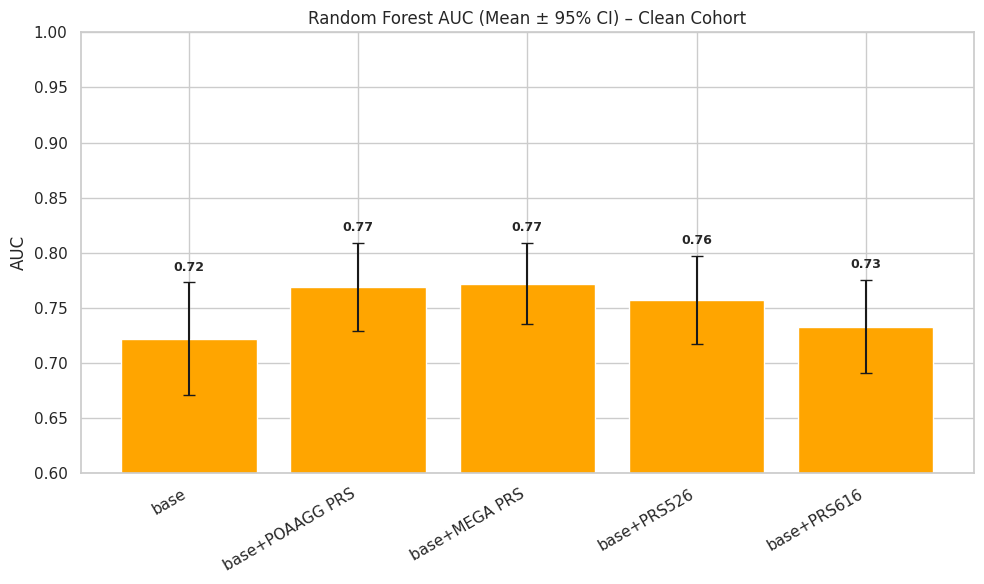

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

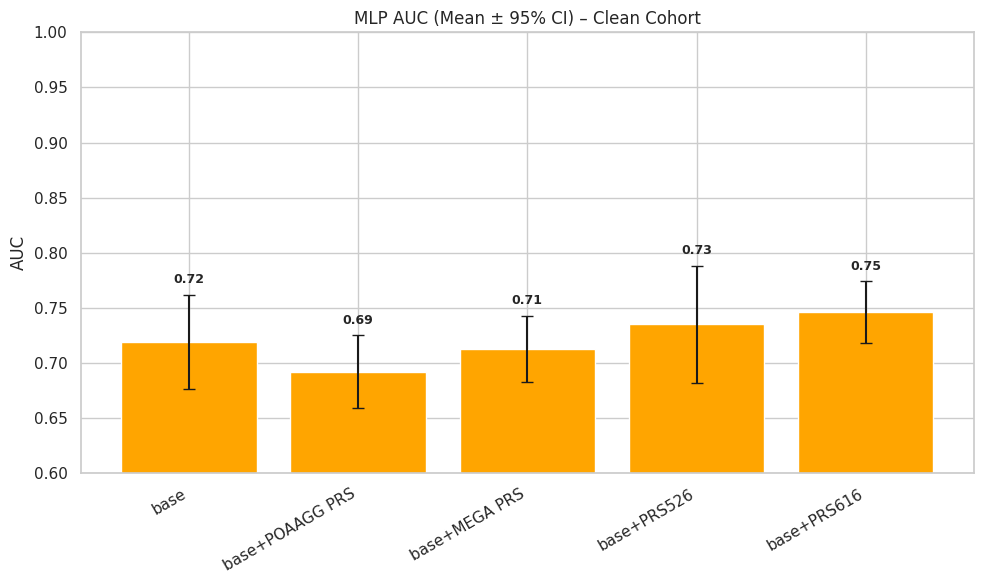

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

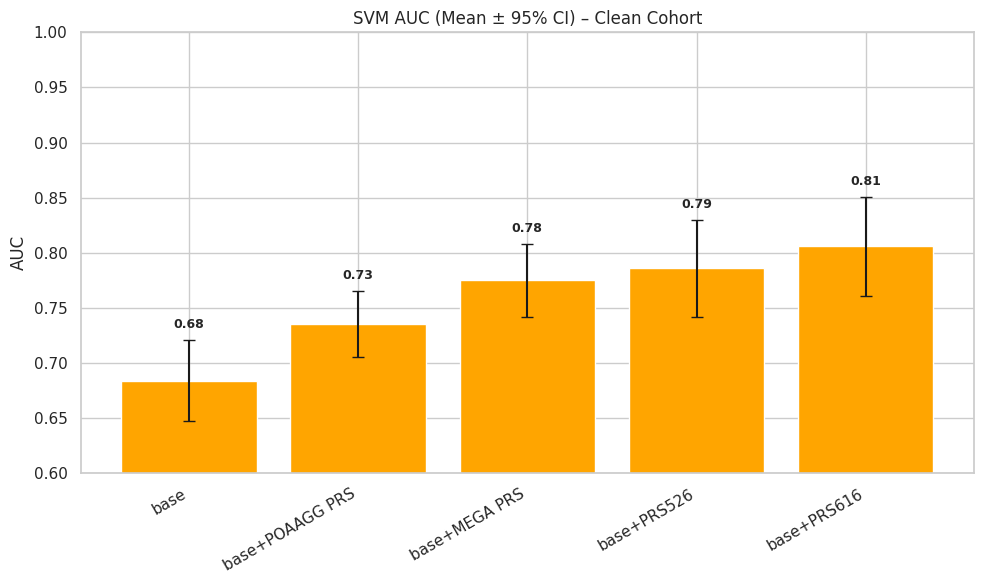

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

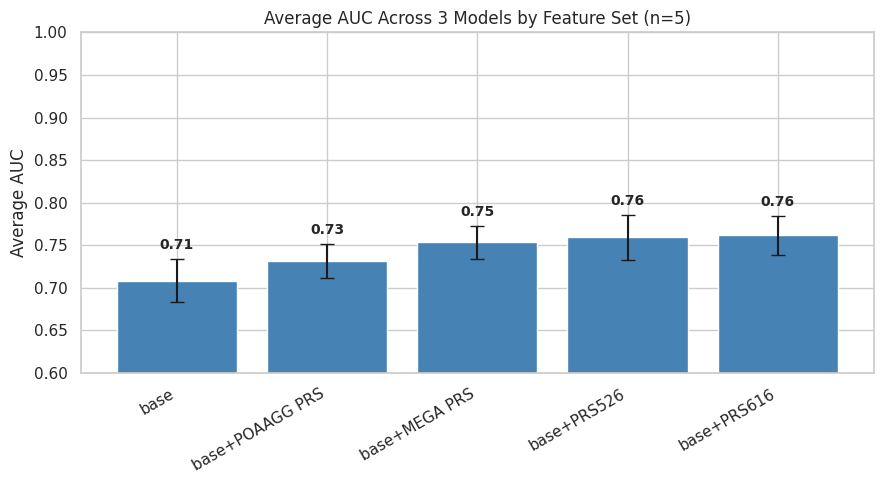

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

# Load results
results_df = pd.read_excel("clean_cohort_model_results.xlsx")

# Filter AUC results for selected feature sets
selected_features = [
    "base", "base+POAAGG PRS", "base+MEGA PRS", "base+PRS526", "base+PRS616"
]

plot_df = results_df[
    (results_df["Metric"] == "AUC") &
    (results_df["Feature Set"].isin(selected_features))
].copy()

# Extract error values from "±" part of CI (e.g., "0.78 ± 0.03")
plot_df["Error"] = plot_df["95% CI"].str.extract(r"±\s*([0-9.]+)").astype(float)

# Sort and plot each model individually
feature_order = selected_features
models_to_plot = ["Random Forest", "MLP", "SVM"]

for model_name in models_to_plot:
    model_df = plot_df[plot_df["Model"] == model_name]
    model_df = model_df.set_index("Feature Set").reindex(feature_order).reset_index()

    x = np.arange(len(model_df))
    y = model_df["Mean"].values
    yerr = model_df["Error"].values

    plt.figure(figsize=(10, 6))
    bars = plt.bar(x, y, yerr=yerr, capsize=4, color="orange")
    plt.xticks(x, model_df["Feature Set"], rotation=30, ha="right")
    plt.ylim(0.6, 1.0)
    plt.ylabel("AUC")
    plt.title(f"{model_name} AUC (Mean ± 95% CI) – Clean Cohort")

    for i, (val, err) in enumerate(zip(y, yerr)):
        y_offset = (plt.ylim()[1] - plt.ylim()[0]) * 0.02
        plt.text(i, val + err + y_offset, f"{val:.2f}",
                 ha="center", va="bottom", fontsize=9, fontweight="bold")

    plt.tight_layout()
    fig_name = f"clean_cohort_AUC_for_{model_name.replace(' ', '')}.png"
    plt.savefig(fig_name, dpi=300)
    plt.show()

    files.download(fig_name)

# === NEW PLOT: Average AUC across the 3 models (RF, MLP, SVM) for each feature set ===
# Keep only the three models we want to average across
df3 = plot_df[plot_df["Model"].isin(models_to_plot)].copy()

# Group by feature set, averaging over the 3 models
# - Mean_AUC: mean of 'Mean' across the 3 models for that feature set
# - Error: combine errors via root-sum-of-squares and divide by count (3)
summary_df = df3.groupby("Feature Set").agg(
    Mean_AUC=("Mean", "mean"),
    Error=("Error", lambda x: np.sqrt(np.sum(np.square(x))) / len(x))
).reindex(feature_order).reset_index()

x = np.arange(len(summary_df))
y = summary_df["Mean_AUC"].values
yerr = summary_df["Error"].values

plt.figure(figsize=(9, 5))
bars = plt.bar(x, y, yerr=yerr, capsize=5, color="steelblue")
plt.xticks(x, summary_df["Feature Set"], rotation=30, ha="right")
plt.ylim(0.6, 1.0)
plt.ylabel("Average AUC")
plt.title(f"Average AUC Across 3 Models by Feature Set (n={len(selected_features)})")

for i, (val, err) in enumerate(zip(y, yerr)):
    y_offset = (plt.ylim()[1] - plt.ylim()[0]) * 0.02
    plt.text(i, val + err + y_offset, f"{val:.2f}",
             ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.tight_layout()
summary_fig_name = "clean_cohort_Average_AUC_across_models_by_feature_set.png"
plt.savefig(summary_fig_name, dpi=300)
plt.show()

files.download(summary_fig_name)


In [9]:
# ✅ Manually export and download suspect risks
risk_export_df.to_excel("Predicted_Risks_Suspects.xlsx", index=False)
files.download("Predicted_Risks_Suspects.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-1655207208.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_plot.groupby("RiskBin")[clinical].agg(["mean", "count", "std"]).reset_index()


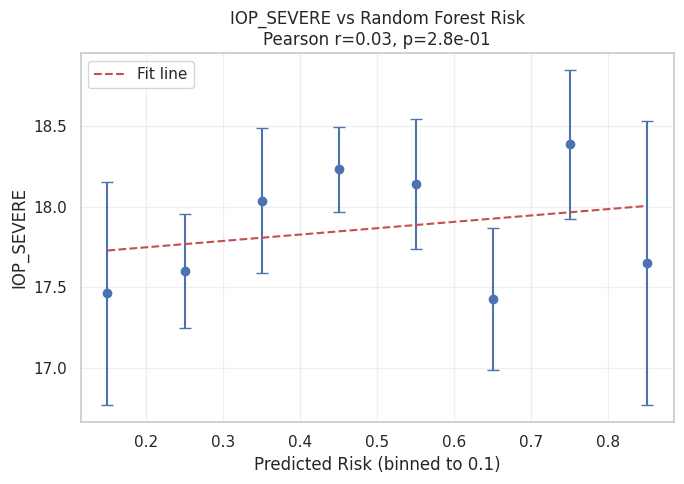

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-1655207208.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_plot.groupby("RiskBin")[clinical].agg(["mean", "count", "std"]).reset_index()


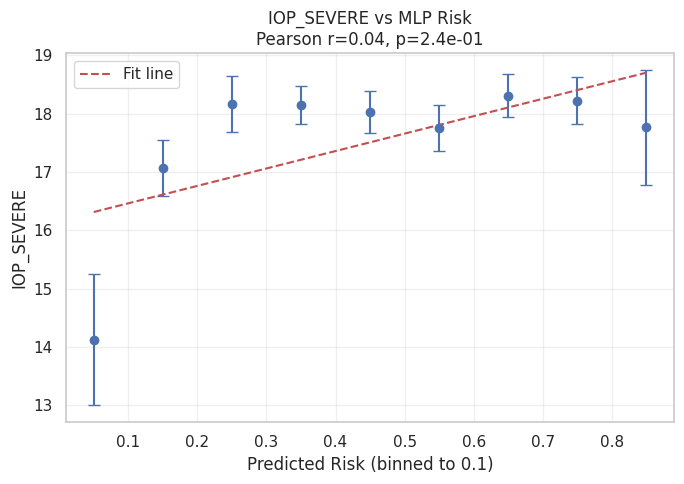

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-1655207208.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_plot.groupby("RiskBin")[clinical].agg(["mean", "count", "std"]).reset_index()


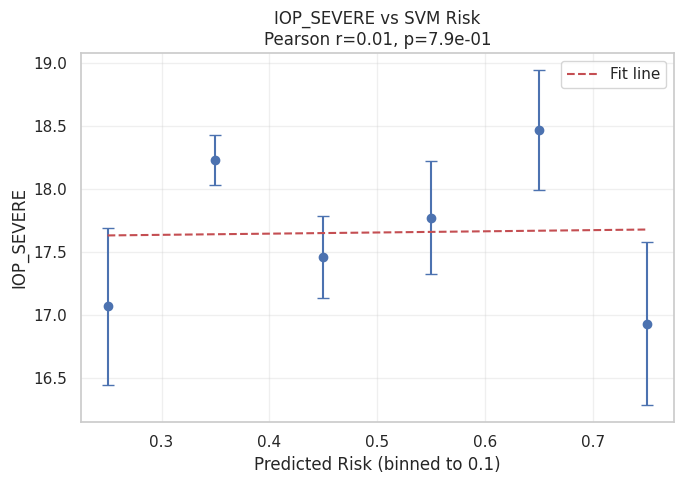

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-1655207208.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_plot.groupby("RiskBin")[clinical].agg(["mean", "count", "std"]).reset_index()


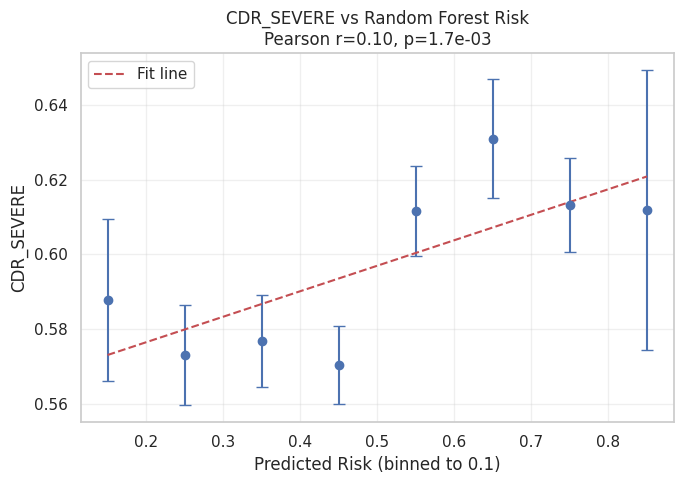

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-1655207208.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_plot.groupby("RiskBin")[clinical].agg(["mean", "count", "std"]).reset_index()


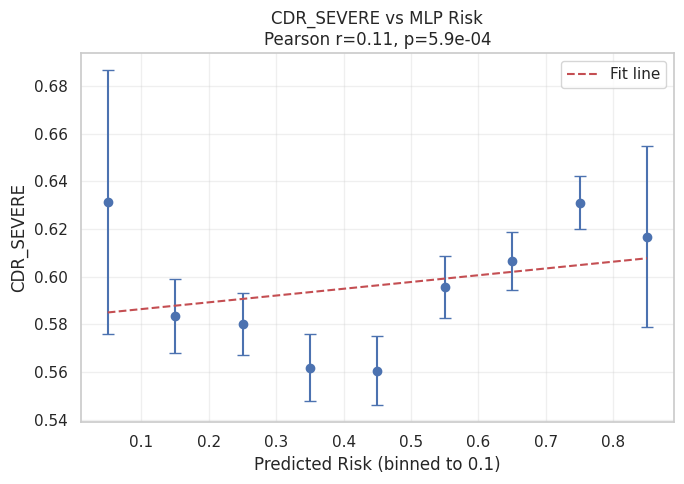

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-1655207208.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_plot.groupby("RiskBin")[clinical].agg(["mean", "count", "std"]).reset_index()


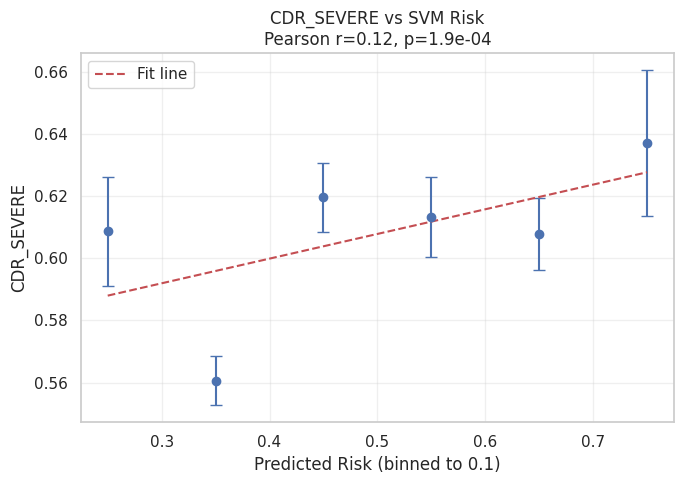

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-1655207208.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_plot.groupby("RiskBin")[clinical].agg(["mean", "count", "std"]).reset_index()


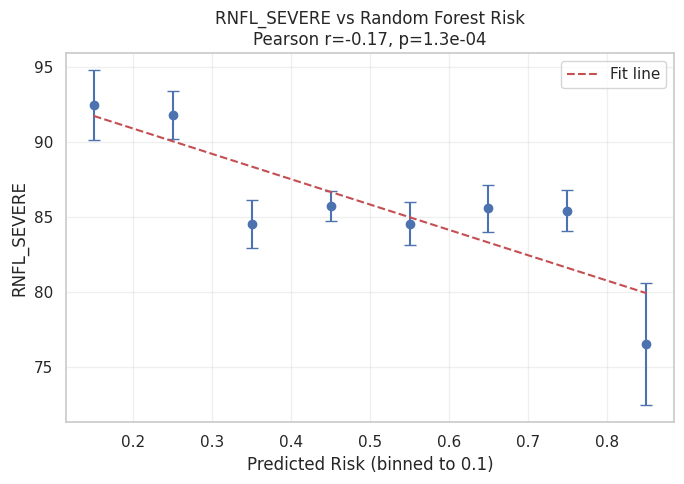

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-1655207208.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_plot.groupby("RiskBin")[clinical].agg(["mean", "count", "std"]).reset_index()


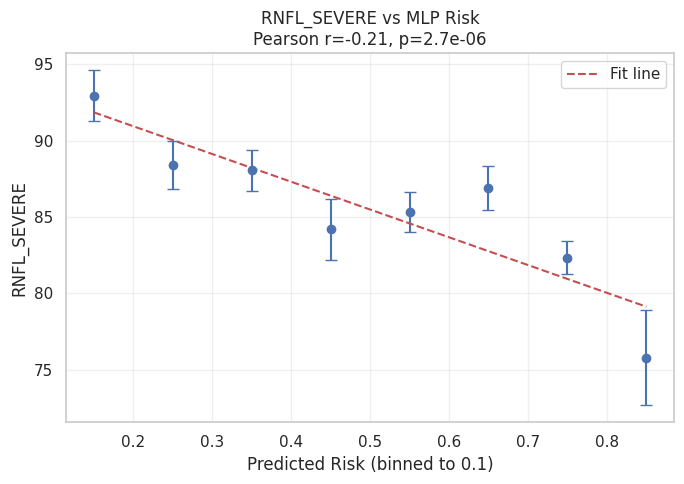

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-1655207208.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_plot.groupby("RiskBin")[clinical].agg(["mean", "count", "std"]).reset_index()


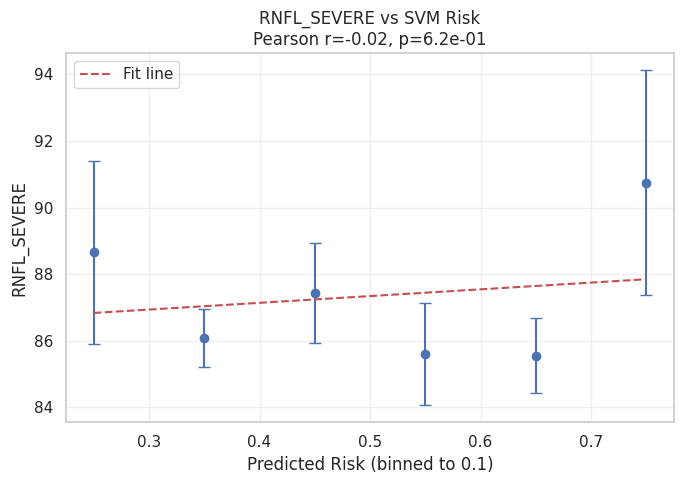

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr
from google.colab import files

# Load suspect data
suspect_df = pd.read_excel("Predicted_Risks_Suspects.xlsx")

# ✅ Update these if your column names differ
risk_cols = {
    "Random Forest": "Random Forest_Risk",
    "MLP": "MLP_Risk",
    "SVM": "SVM_Risk",
}
clinical_markers = ["IOP_SEVERE", "CDR_SEVERE", "RNFL_SEVERE"]

bin_width = 0.1
bins = np.arange(0.0, 1.0 + bin_width, bin_width)

for clinical in clinical_markers:
    for model_name, risk_col in risk_cols.items():
        if risk_col not in suspect_df.columns:
            print(f"⚠️ Skipping {model_name} (column {risk_col} not found)")
            continue

        # Raw data for correlation and fallback fit
        df_plot = suspect_df[[risk_col, clinical]].dropna().copy()
        if df_plot.empty or df_plot[risk_col].nunique() < 2:
            print(f"⚠️ Not enough data variation for {model_name} / {clinical}; skipping plot.")
            continue

        # Pearson correlation on RAW (not binned) data
        try:
            r_val, p_val = pearsonr(df_plot[risk_col].values, df_plot[clinical].values)
        except Exception:
            r_val, p_val = np.nan, np.nan

        # Bin risks for the errorbar plot
        df_plot["RiskBin"] = pd.cut(
            df_plot[risk_col],
            bins,
            labels=np.round(bins[:-1], 1),  # labels are left edges (0.0, 0.1, ...)
            include_lowest=True
        )
        grouped = df_plot.groupby("RiskBin")[clinical].agg(["mean", "count", "std"]).reset_index()
        grouped["sem"] = grouped["std"] / np.sqrt(grouped["count"])
        # When count==1, std is NaN -> make sem=0 so we still show a point without error bar
        grouped["sem"] = grouped["sem"].fillna(0.0)
        # Convert bin label to numeric (left edge); use bin centers for x
        grouped = grouped.dropna(subset=["mean"])
        grouped["RiskBinCenter"] = grouped["RiskBin"].astype(float) + bin_width / 2.0

        # === Fit line ===
        # Prefer fitting to binned means if we have >=2 bins; otherwise fit to raw points.
        have_enough_bins = grouped["RiskBinCenter"].nunique() >= 2
        if have_enough_bins:
            x_fit_src = grouped["RiskBinCenter"].values
            y_fit_src = grouped["mean"].values
        else:
            x_fit_src = df_plot[risk_col].values
            y_fit_src = df_plot[clinical].values

        # np.polyfit is more forgiving; guarantees a line if we have >=2 distinct x
        slope, intercept = np.polyfit(x_fit_src, y_fit_src, 1)

        # Make the plot
        plt.figure(figsize=(7, 5))
        # Errorbar plot using the binned means
        if not grouped.empty:
            plt.errorbar(
                grouped["RiskBinCenter"], grouped["mean"],
                yerr=grouped["sem"], fmt="o", capsize=4
            )

        # Plot fitted line (no R^2 displayed)
        x_line_min = (grouped["RiskBinCenter"].min()
                      if have_enough_bins else df_plot[risk_col].min())
        x_line_max = (grouped["RiskBinCenter"].max()
                      if have_enough_bins else df_plot[risk_col].max())
        x_line = np.linspace(x_line_min, x_line_max, 100)
        y_line = intercept + slope * x_line
        plt.plot(x_line, y_line, 'r--', label="Fit line")

        # Titles/labels — hide R²; keep Pearson r, p in title as requested
        plt.title(f"{clinical} vs {model_name} Risk\nPearson r={r_val:.2f}, p={p_val:.1e}")
        plt.xlabel("Predicted Risk (binned to 0.1)")
        plt.ylabel(clinical)
        plt.legend()
        plt.grid(alpha=0.3)

        fig_name = f"clinical_enrichment_{clinical}_{model_name.replace(' ', '')}.png"
        plt.tight_layout()
        plt.savefig(fig_name, dpi=300)
        plt.show()
        files.download(fig_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

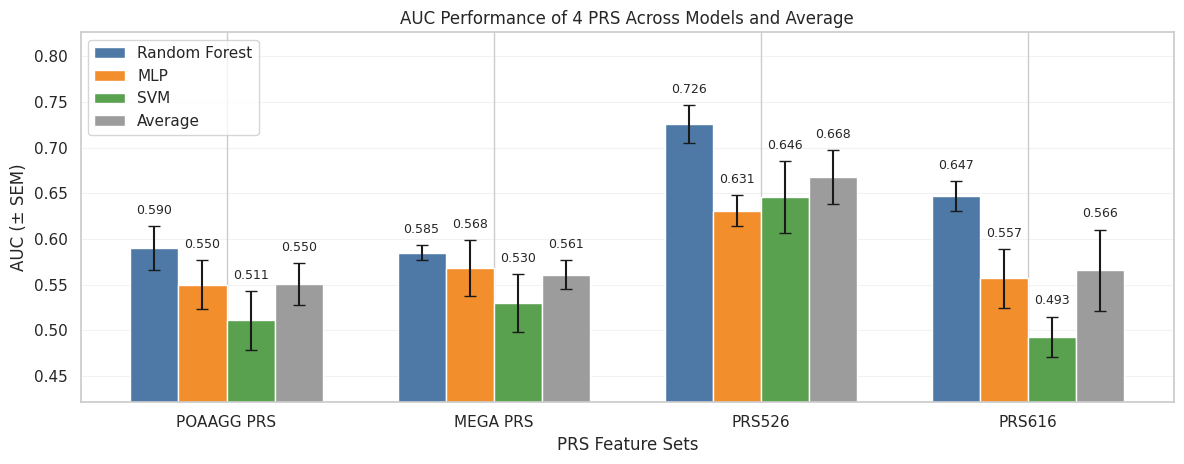

In [11]:
# --- AUC bar chart for 4 PRS: RF, MLP, SVM, and their Average (with SEM and improved labels) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Load results produced earlier by the pipeline
results = pd.read_excel("clean_cohort_model_results.xlsx")

# Keep only AUC rows and the four PRS of interest
PRS_ORDER = ["POAAGG PRS", "MEGA PRS", "PRS526", "PRS616"]
df = results[(results["Metric"].str.upper() == "AUC") & (results["Feature Set"].isin(PRS_ORDER))].copy()

# Extract half-width of 95% CI (text like "± 0.04") and convert to SEM = halfwidth / 1.96
hw = df["95% CI"].astype(str).str.extract(r"±\s*([0-9.]+)")[0].astype(float)
df["SEM"] = hw / 1.96

# Ensure deterministic PRS ordering
df["Feature Set"] = pd.Categorical(df["Feature Set"], categories=PRS_ORDER, ordered=True)
df = df.sort_values(["Feature Set", "Model"])

# Helper to get arrays by feature set for a given model
def get_by_model(model_name):
    sub = df[df["Model"] == model_name].set_index("Feature Set").reindex(PRS_ORDER)
    return sub["Mean"].values, sub["SEM"].values

rf_mean, rf_sem = get_by_model("Random Forest")
mlp_mean, mlp_sem = get_by_model("MLP")
svm_mean, svm_sem = get_by_model("SVM")

# Average across the three models for each PRS
means_stack = np.vstack([rf_mean, mlp_mean, svm_mean])  # shape (3, 4)
avg_mean = means_stack.mean(axis=0)
avg_sem = means_stack.std(axis=0, ddof=1) / np.sqrt(means_stack.shape[0])  # SEM across models

# --- Plot ---
x = np.arange(len(PRS_ORDER))  # positions for the 4 PRS
width = 0.18                   # bar width (grouped)
offsets = [-1.5*width, -0.5*width, 0.5*width, 1.5*width]

plt.figure(figsize=(12, 4.8))

bars_rf = plt.bar(x + offsets[0], rf_mean, yerr=rf_sem, capsize=4, width=width, label="Random Forest", color="#4e79a7")
bars_mlp = plt.bar(x + offsets[1], mlp_mean, yerr=mlp_sem, capsize=4, width=width, label="MLP",           color="#f28e2b")
bars_svm = plt.bar(x + offsets[2], svm_mean, yerr=svm_sem, capsize=4, width=width, label="SVM",           color="#59a14f")
bars_avg = plt.bar(x + offsets[3], avg_mean, yerr=avg_sem, capsize=4, width=width, label="Average",       color="#9c9c9c")

plt.xticks(x, PRS_ORDER, rotation=0)
plt.ylabel("AUC (± SEM)")
plt.xlabel("PRS Feature Sets")
plt.title("AUC Performance of 4 PRS Across Models and Average")
plt.grid(axis="y", alpha=0.25, linewidth=0.8)

# Nice y-limits with headroom but within [0, 1.1]
all_means = np.concatenate([rf_mean, mlp_mean, svm_mean, avg_mean])
all_sems  = np.concatenate([rf_sem,  mlp_sem,  svm_sem,  avg_sem])
ymax = float(np.nanmax(all_means + all_sems)) if len(all_means) else 1.0
ymin = float(np.nanmin(all_means - all_sems)) if len(all_means) else 0.0
pad = 0.05
plt.ylim(max(0, ymin - pad), min(1.1, ymax + 0.08))

plt.legend(loc="upper left", frameon=True)

# --- Number labels on top of bars (above the SEM cap) ---
def label_bars(bars, sem=None, offset=0.01):
    for i, b in enumerate(bars):
        h = b.get_height()
        err = sem[i] if sem is not None and i < len(sem) and np.isfinite(sem[i]) else 0
        plt.text(
            b.get_x() + b.get_width()/2,
            h + err + offset,       # place above top of error bar
            f"{h:.3f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

label_bars(bars_rf, rf_sem)
label_bars(bars_mlp, mlp_sem)
label_bars(bars_svm, svm_sem)
label_bars(bars_avg, avg_sem)

plt.tight_layout()
out_png = "AUC_4PRS_RF_MLP_SVM_Average_Labeled.png"
#out_pdf = "AUC_4PRS_RF_MLP_SVM_Average_Labeled.pdf"
plt.savefig(out_png, dpi=300)
#plt.savefig(out_pdf)

# Download in Colab (safe no-op elsewhere)
try:
    from google.colab import files as _colab_files
    _colab_files.download(out_png)
    #_colab_files.download(out_pdf)
except Exception:
    pass

plt.show()


In [12]:
# STEP 1: Upload your clean cohort Excel file for asymmetry
# The variable `train_df` is already loaded from "271_training_cohort_4_new_PRS_cleaned.xlsx"
import pandas as pd
import numpy as np

# Assign for consistency with old code
df = train_df.copy()

# Define feature sets (Δ = inter-eye asymmetry)
# Replaced GRS1–4 with: 'POAAGG PRS', 'MEGA PRS', 'PRS526', 'PRS616'
# Removed 'POAAGG PRS'
feature_sets = {
    # --- ΔIOP based ---
    "ΔIOP": ['delta_IOP'],
    "ΔIOP+POAAGG PRS": ['delta_IOP', 'POAAGG PRS'],
    "ΔIOP+MEGA PRS":   ['delta_IOP', 'MEGA PRS'],
    "ΔIOP+PRS526":      ['delta_IOP', 'PRS526'],
    "ΔIOP+PRS616":      ['delta_IOP', 'PRS616'],

    # --- ΔCDR based ---
    "ΔCDR": ['delta_CDR'],
    "ΔCDR+POAAGG PRS": ['delta_CDR', 'POAAGG PRS'],
    "ΔCDR+MEGA PRS":   ['delta_CDR', 'MEGA PRS'],
    "ΔCDR+PRS526":      ['delta_CDR', 'PRS526'],
    "ΔCDR+PRS616":      ['delta_CDR', 'PRS616'],

    # --- ΔRNFL based ---
    "ΔRNFL": ['delta_RNFL'],
    "ΔRNFL+POAAGG PRS": ['delta_RNFL', 'POAAGG PRS'],
    "ΔRNFL+MEGA PRS":   ['delta_RNFL', 'MEGA PRS'],
    "ΔRNFL+PRS526":      ['delta_RNFL', 'PRS526'],
    "ΔRNFL+PRS616":      ['delta_RNFL', 'PRS616']
}

# Ensure CaseCtrl column is present and correctly formatted
df = df.dropna(subset=['CaseCtrl'])
df['CaseCtrl'] = df['CaseCtrl'].astype(int)

print(f"✅ Loaded {len(df)} individuals")
print(f"Available feature sets: {len(feature_sets)} (ΔIOP, ΔCDR, ΔRNFL with PRS combinations)")


✅ Loaded 271 individuals
Available feature sets: 15 (ΔIOP, ΔCDR, ΔRNFL with PRS combinations)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression

# Define models
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=300,                 # a few more trees → smoother, stabler AUC
        max_depth=5,                      # allow a bit more structure (was 3)
        min_samples_split=20,             # loosen split constraint (was 50)
        min_samples_leaf=10,              # smaller leaves, still regularized (was 25)
        max_features=1.0,                 # consider all features (or "sqrt" if >10 features)
        bootstrap=True,
        class_weight="balanced_subsample",
        ccp_alpha=0.001,                  # lighter post-pruning (was 0.005)
        random_state=42
    ),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        alpha=1e-3,                   # stronger L2 for bigger net
        learning_rate_init=1e-3,
        batch_size=32,
        max_iter=2000,
        early_stopping=True,
        n_iter_no_change=50,
        validation_fraction=0.20,
        random_state=42
    ),

    "SVM": SVC(
        kernel="rbf",
        C=4.0,                        # looser regularization → sharper boundary
        gamma=2.0,                    # more localized kernel
        class_weight="balanced",
        probability=True,
        tol=1e-4,
        cache_size=1000,
        random_state=42
    ),
    "Logistic Regression": LogisticRegression(
        solver="liblinear",           # robust for small datasets
        penalty="l2",                 # standard L2 regularization
        C=1.0,                        # inverse regularization strength
        class_weight="balanced",      # adjusts for class imbalance
        max_iter=1000,
        random_state=42
    )
}

# Bootstrap and evaluate
results = []
n_bootstraps = 10

for fs_name, features in feature_sets.items():
    X = df[features]
    y = df['CaseCtrl']

    for model_name, model in models.items():
        metrics = {
            "Accuracy": [], "F1": [], "AUC": [],
            "Sensitivity": [], "Specificity": []
        }

        for _ in range(n_bootstraps):
            X_resample, y_resample = resample(X, y, stratify=y)
            pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler()),
                ('clf', model)
            ])
            X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.2)
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            y_prob = pipeline.predict_proba(X_test)[:, 1]

            report = classification_report(y_test, y_pred, output_dict=True)
            metrics['Accuracy'].append(report['accuracy'])
            metrics['F1'].append(report['1']['f1-score'])
            metrics['Sensitivity'].append(report['1']['recall'])
            metrics['Specificity'].append(report['0']['recall'])
            metrics['AUC'].append(roc_auc_score(y_test, y_prob))

        for metric, values in metrics.items():
            mean = np.mean(values)
            std = np.std(values)
            ci = 1.96 * (std / np.sqrt(len(values)))
            results.append({
                "Feature Set": fs_name,
                "Model": model_name,
                "Metric": metric,
                "Mean": round(mean, 3),
                "95% CI": f"{round(mean, 3)} ± {round(ci, 3)}"
            })

# Save results
results_df = pd.DataFrame(results)
results_df.to_excel("clean_cohort_model_results_Asymmetry.xlsx", index=False)
files.download("clean_cohort_model_results_Asymmetry.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

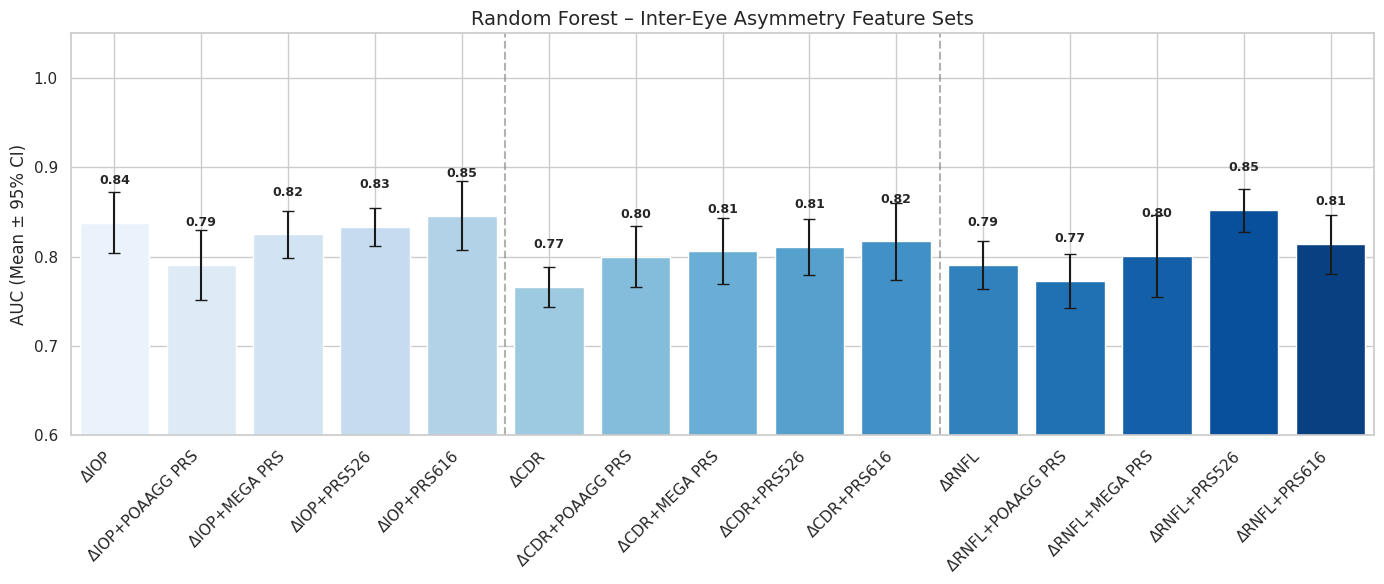

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

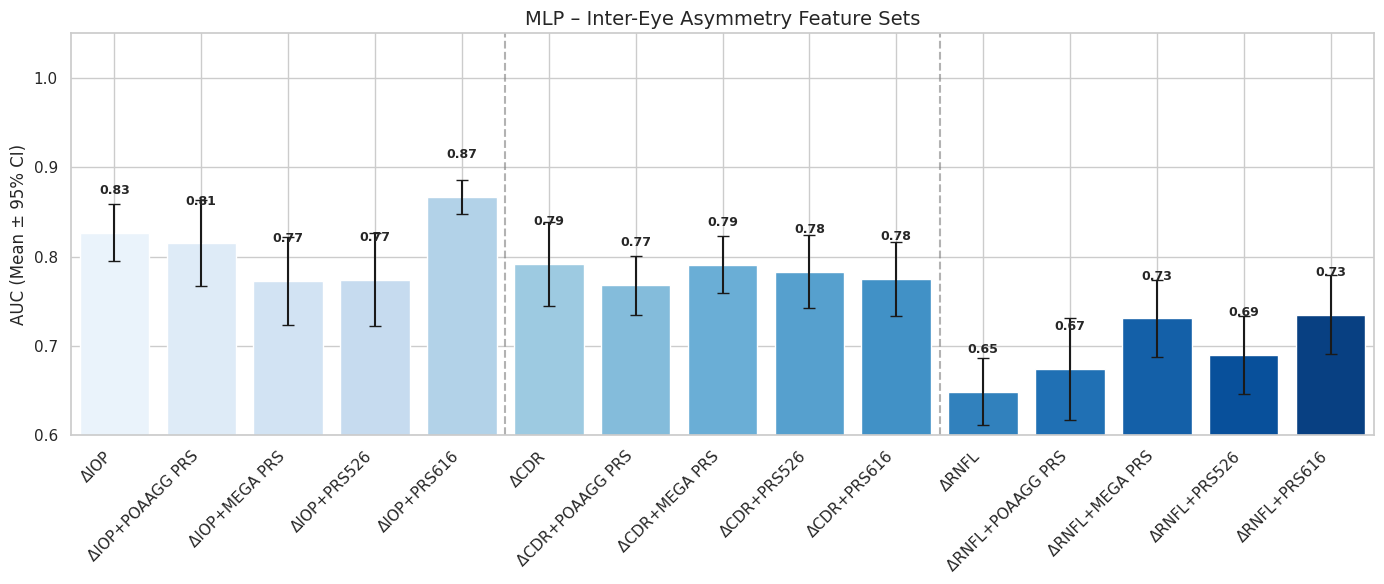

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

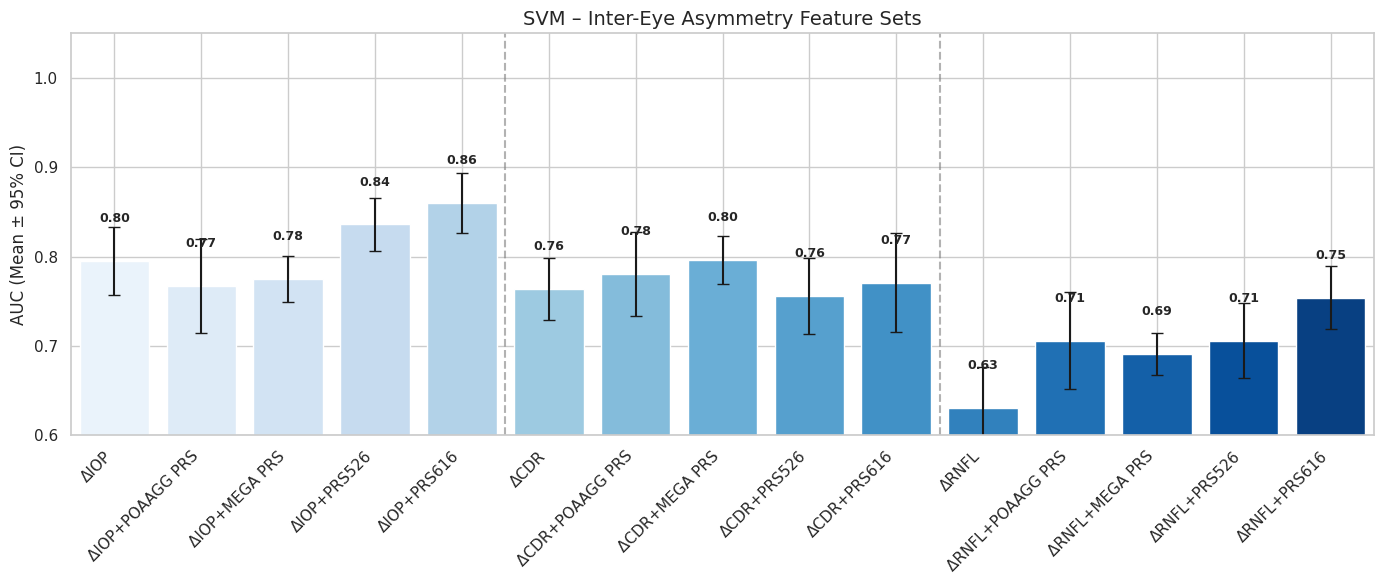

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

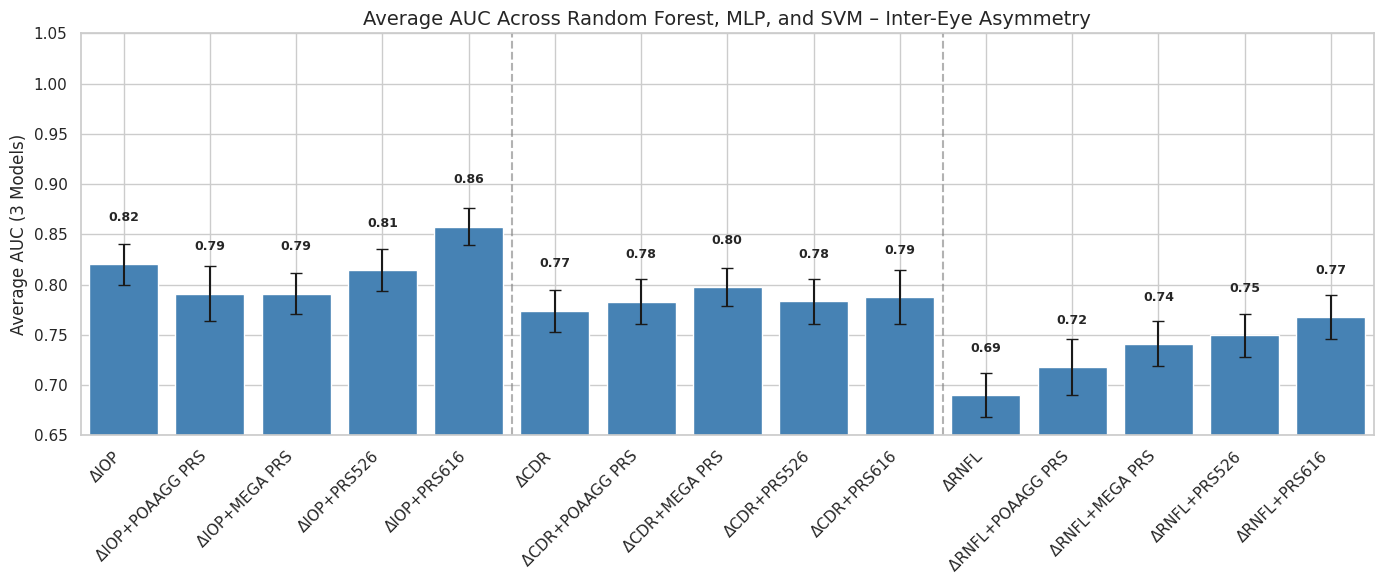

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Load results
results_df = pd.read_excel("clean_cohort_model_results_Asymmetry.xlsx")

# Filter for AUC only
auc_df = results_df[results_df["Metric"] == "AUC"].copy()
auc_df["Error"] = auc_df["95% CI"].str.extract(r"±\s*([0-9.]+)").astype(float)

# Order feature sets ΔIOP → ΔCDR → ΔRNFL
feature_order = [fs for fs in auc_df["Feature Set"].unique() if fs.startswith("ΔIOP")] + \
                [fs for fs in auc_df["Feature Set"].unique() if fs.startswith("ΔCDR")] + \
                [fs for fs in auc_df["Feature Set"].unique() if fs.startswith("ΔRNFL")]

models_to_plot = ["Random Forest", "MLP", "SVM"]
palette = sns.color_palette("Blues", n_colors=len(feature_order))

# === Individual Model Plots ===
for model_name in models_to_plot:
    model_df = auc_df[auc_df["Model"] == model_name].set_index("Feature Set").reindex(feature_order).reset_index()

    x = np.arange(len(model_df))
    y = model_df["Mean"].values
    yerr = model_df["Error"].values

    plt.figure(figsize=(14, 6))
    bars = plt.bar(x, y, yerr=yerr, capsize=4, color=palette)
    plt.xticks(x, model_df["Feature Set"], rotation=45, ha="right")
    plt.ylabel("AUC (Mean ± 95% CI)")
    plt.ylim(0.60, 1.05)
    plt.title(f"{model_name} – Inter-Eye Asymmetry Feature Sets", fontsize=14)

    # Vertical dashed lines separating groups automatically
    group_size = len(feature_order) // 3  # Roughly 3 groups: ΔIOP, ΔCDR, ΔRNFL
    for i in range(group_size, len(feature_order), group_size):
        plt.axvline(i - 0.5, color="gray", linestyle="--", alpha=0.6)

    # Fix x-axis limits tightly around your data
    plt.xlim(-0.5, len(feature_order) - 0.5)


    # Annotate bar tops
    for i, val in enumerate(y):
        plt.text(i, val + 0.04, f"{val:.2f}", ha="center", va="bottom", fontsize=9, fontweight='bold')

    plt.tight_layout()
    fig_name = f"AUC_Asymmetry_{model_name.replace(' ', '')}.png"
    plt.savefig(fig_name, dpi=300)
    files.download(fig_name)
    plt.show()


# === NEW PLOT: Average AUC across the 3 models (RF, MLP, SVM) ===
avg_df = auc_df[auc_df["Model"].isin(models_to_plot)].groupby("Feature Set").agg(
    Mean_AUC=("Mean", "mean"),
    Error=("Error", lambda x: np.sqrt(np.sum(np.square(x))) / len(x))
).reindex(feature_order).reset_index()

x = np.arange(len(avg_df))
y = avg_df["Mean_AUC"].values
yerr = avg_df["Error"].values

plt.figure(figsize=(14, 6))
bars = plt.bar(x, y, yerr=yerr, capsize=4, color="steelblue")
plt.xticks(x, avg_df["Feature Set"], rotation=45, ha="right")
plt.ylabel("Average AUC (3 Models)")
plt.ylim(0.65, 1.05)
plt.title("Average AUC Across Random Forest, MLP, and SVM – Inter-Eye Asymmetry", fontsize=14)

# Vertical dashed lines separating groups automatically
group_size = len(feature_order) // 3  # Roughly 3 groups: ΔIOP, ΔCDR, ΔRNFL
for i in range(group_size, len(feature_order), group_size):
    plt.axvline(i - 0.5, color="gray", linestyle="--", alpha=0.6)

# Fix x-axis limits tightly around your data
plt.xlim(-0.5, len(feature_order) - 0.5)


# Annotate bar tops
for i, val in enumerate(y):
    plt.text(i, val + 0.04, f"{val:.2f}", ha="center", va="bottom", fontsize=9, fontweight='bold')

plt.tight_layout()
summary_fig_name = "AUC_Asymmetry_AverageAcross3Models.png"
plt.savefig(summary_fig_name, dpi=300)
files.download(summary_fig_name)
plt.show()



Figure 2 - Manhattan Plot

In [15]:
# --- Manhattan plotting helper (uses |BETA| as effect magnitude) ---
import numpy as np
import matplotlib.pyplot as plt

def manhattan_from_beta(df, title, outfile_png, outfile_pdf=None):
    # Parse chr/bp from "CHR:BP"
    tmp = df.copy()
    parts = tmp["SNP"].astype(str).str.split(":", n=1, expand=True)
    tmp["CHR"] = parts[0].str.replace("^chr", "", case=False, regex=True)
    tmp["CHR"] = tmp["CHR"].replace({"X": "23", "Y": "24", "MT": "25"})
    tmp["CHR"] = tmp["CHR"].astype(int)
    tmp["BP"]  = parts[1].astype(int)

    # Keep autosomes if you want only 1–22
    tmp = tmp[tmp["CHR"].between(1, 22)]

    # Sort & compute cumulative positions per chromosome
    tmp = tmp.sort_values(["CHR", "BP"])
    chrom_sizes = tmp.groupby("CHR")["BP"].max().sort_index()
    offsets = chrom_sizes.cumsum().shift(fill_value=0)
    tmp["POS"] = tmp["BP"] + tmp["CHR"].map(offsets)

    # X tick positions at chromosome midpoints
    mids = (chrom_sizes.cumsum() - chrom_sizes/2.0).values
    xlabels = chrom_sizes.index.astype(int).astype(str).tolist()

    # Y: absolute effect size
    y = tmp["BETA"].abs().values
    x = tmp["POS"].values

    # Colors alternating by chromosome
    colors = np.where(tmp["CHR"] % 2 == 0, "#4e79a7", "#a0c4ff")

    # Figure size scales with #points (but caps for sanity)
    w = min(16, max(10, len(tmp) / 200))
    plt.figure(figsize=(w, 6))
    plt.scatter(x, y, s=8, c=colors, linewidths=0, alpha=0.8)

    # Axis cosmetics
    plt.xticks(mids, xlabels, fontsize=9)
    plt.xlabel("Chromosome")
    plt.ylabel("|BETA| (effect magnitude)")
    plt.title(title)

    # Optional guide lines (e.g., 95th percentile of |BETA|)
    thr = np.percentile(y, 95)
    plt.axhline(thr, color="gray", linestyle="--", alpha=0.6, linewidth=1)
    plt.text(x.max()*0.995, thr, "95th %ile", ha="right", va="bottom", fontsize=9, color="gray")

    # Tighten layout and x-limits (NumPy ≥2.0 safe)
    x_range = np.ptp(x)  # same as x.max() - x.min()
    plt.xlim(x.min() - x_range * 0.01, x.max() + x_range * 0.01)
    plt.tight_layout()


    # Save
    plt.savefig(outfile_png, dpi=300)
    if outfile_pdf:
        plt.savefig(outfile_pdf)
    print(f"Saved: {outfile_png}" + (f" and {outfile_pdf}" if outfile_pdf else ""))

    # Download (Colab)
    try:
        from google.colab import files as _colab_files
        _colab_files.download(outfile_png)
        if outfile_pdf:
            _colab_files.download(outfile_pdf)
    except Exception:
        pass

    plt.show()


Saved: Manhattan_MTAG_PRS.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

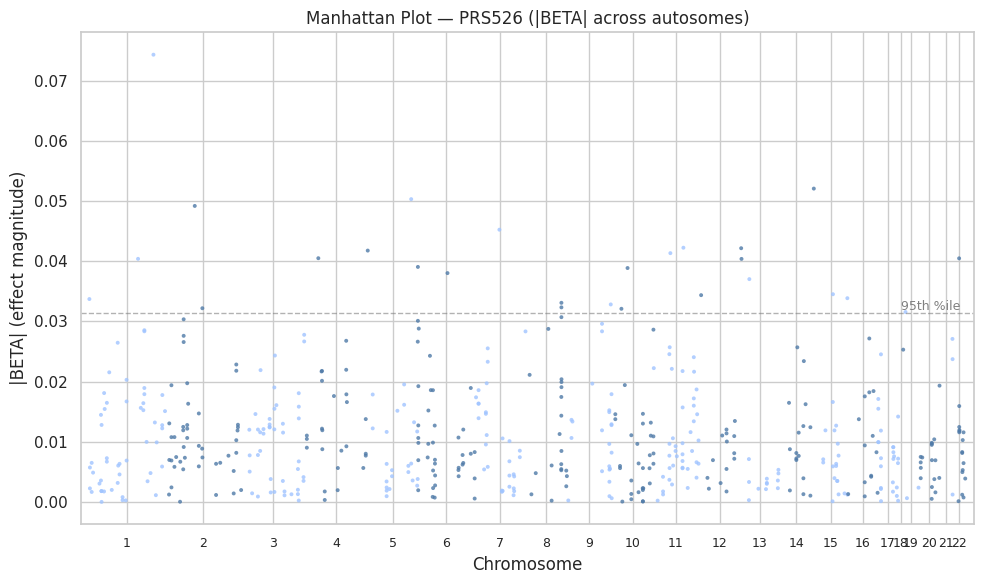

Saved: Manhattan_MEGA_PRS.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

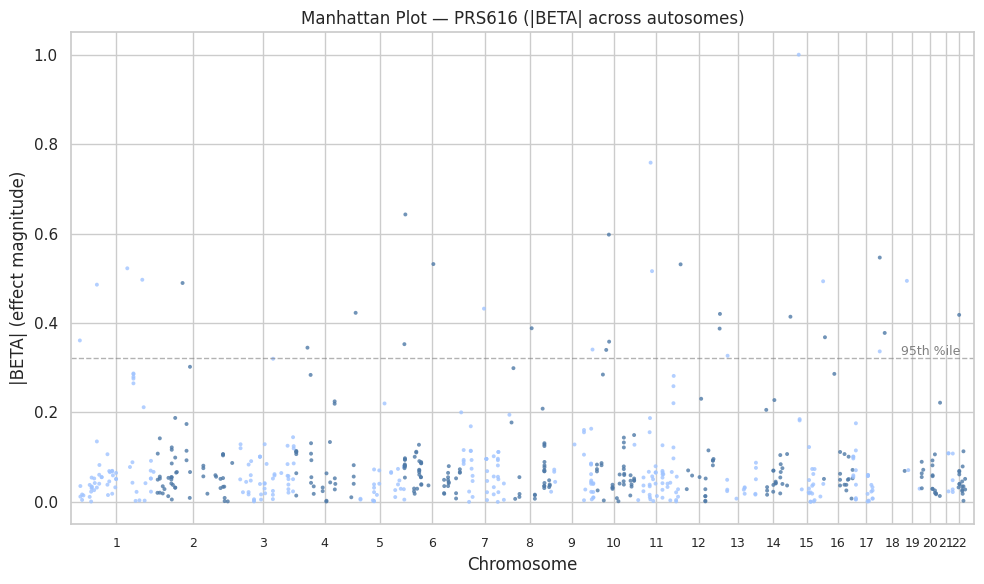

In [16]:
# --- Generate Manhattan-style plots for each PRS ---
manhattan_from_beta(
    mtag_df,
    title="Manhattan Plot — PRS526 (|BETA| across autosomes)",
    outfile_png="Manhattan_MTAG_PRS.png",
    #outfile_pdf="Manhattan_MTAG_PRS.pdf",
)

manhattan_from_beta(
    mega_df,
    title="Manhattan Plot — PRS616 (|BETA| across autosomes)",
    outfile_png="Manhattan_MEGA_PRS.png",
    #outfile_pdf="Manhattan_MEGA_PRS.pdf",
)


Figure 2 - Number of SNPs in each CHR

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

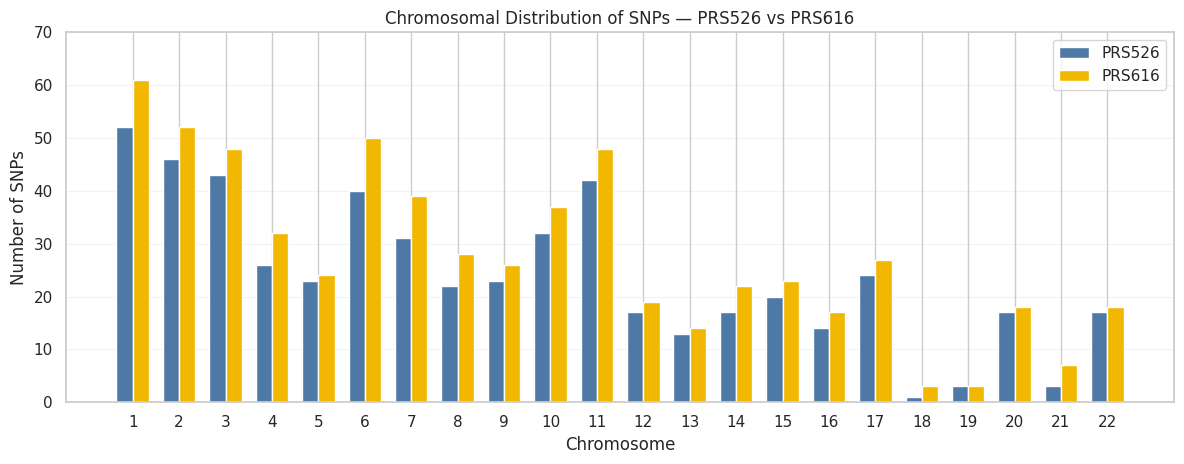

In [17]:
# --- Combined SNP counts per chromosome: PRS526 vs PRS616 (thinner bars) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def snp_counts_by_chr(df):
    """Return a Series of SNP counts indexed by chromosome 1..22."""
    t = df.copy()
    cols = {c.upper(): c for c in t.columns}
    snp_col = cols.get("SNP", None)
    assert snp_col is not None, "Input dataframe must contain an 'SNP' column."
    parts = t[snp_col].astype(str).str.split(":", n=1, expand=True)
    chr_str = parts[0].str.replace(r"^chr", "", case=False, regex=True)
    chr_str = chr_str.replace({"X": "23", "Y": "24", "MT": "25"})
    t["CHR"] = pd.to_numeric(chr_str, errors="coerce")
    t = t[t["CHR"].between(1, 22)]
    counts = t.groupby("CHR").size()
    return counts.reindex(range(1, 23), fill_value=0)

# Build counts from already-loaded dataframes
mtag_counts = snp_counts_by_chr(mtag_df)
mega_counts = snp_counts_by_chr(mega_df)

# Plot grouped bars (slightly thinner)
idx = np.arange(22)
labels = [str(i) for i in range(1, 23)]
width = 0.35  # thinner bars (was 0.45)

plt.figure(figsize=(12, 4.8))
bars1 = plt.bar(idx - width/2, mtag_counts.values, width=width, label="PRS526", color="#4e79a7")
bars2 = plt.bar(idx + width/2, mega_counts.values, width=width, label="PRS616", color="#f2b701")

plt.xticks(idx, labels)
plt.xlabel("Chromosome")
plt.ylabel("Number of SNPs")
plt.title("Chromosomal Distribution of SNPs — PRS526 vs PRS616")

# Add light grid and legend (upper right)
plt.grid(axis="y", alpha=0.25, linewidth=0.8)
plt.legend(loc="upper right", frameon=True)

# Set nice y-limit with padding
ymax = max(mtag_counts.max(), mega_counts.max())
plt.ylim(0, max(5, int(ymax * 1.15)))

plt.tight_layout()
out_png = "SNP_Counts_by_Chromosome_MTAG_vs_MEGA_thin.png"
#out_pdf = "SNP_Counts_by_Chromosome_MTAG_vs_MEGA_thin.pdf"
plt.savefig(out_png, dpi=300)
#plt.savefig(out_pdf)

# Download (works in Colab, safe elsewhere)
try:
    from google.colab import files as _colab_files
    _colab_files.download(out_png)
    #_colab_files.download(out_pdf)
except Exception:
    pass

plt.show()


Figure 2 - violin plot for 4 PRS, with cases, controls, and suspects

/tmp/ipython-input-55948910.py:107: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

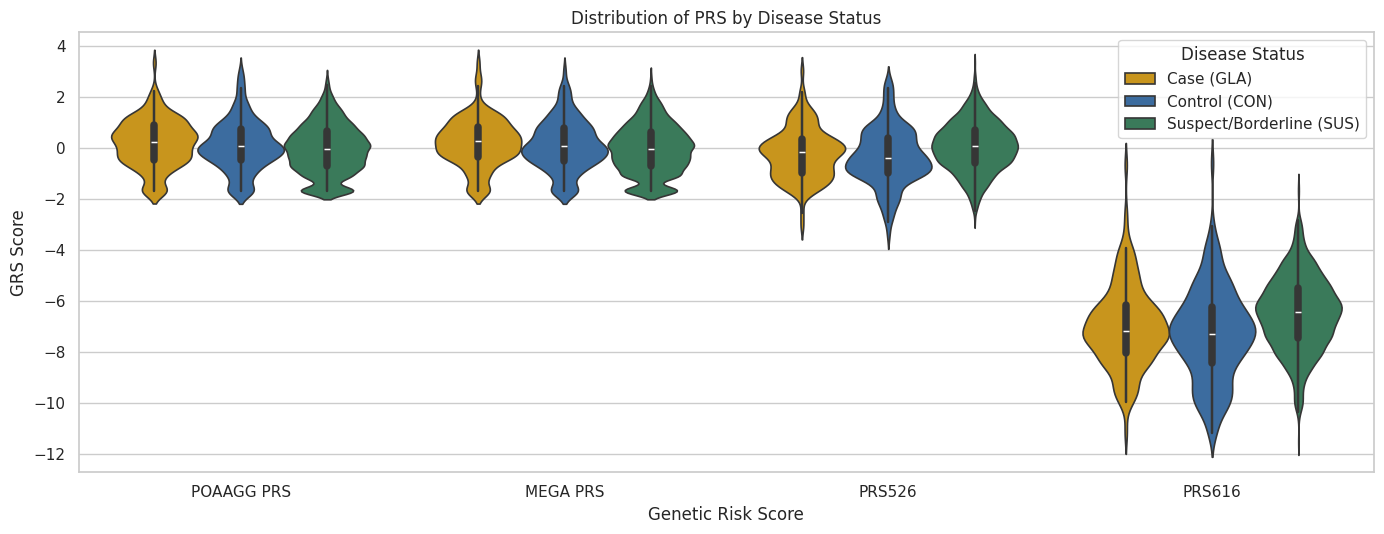

In [18]:
# --- Violin plot for four PRS: robust to 'Disease status' vs 'Disease_status' column names ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Expected PRS labels for plotting (fixed order)
PRS_LABELS = ["POAAGG PRS", "MEGA PRS", "PRS526", "PRS616"]

def _normalize(s: str) -> str:
    """Lowercase and strip all non-alphanumeric chars for robust matching."""
    return re.sub(r"[^0-9a-z]+", "", str(s).lower())

def find_column(df: pd.DataFrame, candidates):
    """
    Return the actual column name in df that matches any of the candidate names,
    ignoring case and punctuation/spacing/underscores.
    """
    norm_map = {_normalize(c): c for c in df.columns}
    for cand in candidates:
        key = _normalize(cand)
        if key in norm_map:
            return norm_map[key]
    return None

def find_prs_columns(df: pd.DataFrame):
    """
    Map our canonical PRS_LABELS -> actual column names in df (robust).
    Raises if any are missing.
    """
    found = {}
    for label in PRS_LABELS:
        variants = [
            label,
            label.replace("-", " "), label.replace("-", "_"),
            label.replace(" ", "_"), label.replace(" ", ""),
            label.replace("_", " "),
        ]
        col = find_column(df, variants)
        if col is None:
            raise KeyError(
                f"Could not find PRS column matching '{label}' in dataframe. "
                f"Available columns (sample): {list(df.columns)[:10]}"
            )
        found[label] = col
    return found

def clean_status(s):
    """Map raw disease status strings to canonical 3-category labels."""
    s = str(s).lower()
    if "case" in s:
        return "Case (GLA)"
    if "control" in s:
        return "Control (CON)"
    if "suspect" in s or "borderline" in s or "sus" in s:
        return "Suspect/Borderline (SUS)"
    return np.nan

def melt_long(df: pd.DataFrame, prs_map: dict, status_col_name: str, source_label: str):
    """Keep PRS + status, melt long, add source label."""
    use = df[[status_col_name] + list(prs_map.values())].copy()
    use["Status"] = use[status_col_name].map(clean_status)
    long = use.melt(
        id_vars=["Status"], value_vars=list(prs_map.values()),
        var_name="PRS_actual", value_name="Score"
    ).dropna(subset=["Status", "Score"])
    # Replace actual column names by our canonical labels
    inv_map = {v: k for k, v in prs_map.items()}
    long["PRS"] = long["PRS_actual"].map(inv_map)
    long = long.drop(columns=["PRS_actual"])
    long["Source"] = source_label
    return long

# --- Detect columns in each dataframe (train_df and test_1013_df are assumed to exist)
status_candidates = ["Disease status", "Disease_status", "disease status", "disease_status"]

# Training DF (cases + controls)
train_status_col = find_column(train_df, status_candidates)
assert train_status_col is not None, "Could not find a disease-status column in training data."
train_prs_map = find_prs_columns(train_df)
train_long = melt_long(train_df, train_prs_map, train_status_col, "Training (271)")

# Testing DF (suspects)
test_status_col = find_column(test_1013_df, status_candidates)
assert test_status_col is not None, "Could not find a disease-status column in 1013 testing data."
test_prs_map = find_prs_columns(test_1013_df)
sus_long = melt_long(test_1013_df, test_prs_map, test_status_col, "Testing (1013)")

# Keep only the 3 categories and only rows where category exists
pooled = pd.concat([train_long, sus_long], ignore_index=True)
pooled = pooled[pooled["Status"].isin(["Case (GLA)", "Control (CON)", "Suspect/Borderline (SUS)"])]

# Ensure PRS order exactly as requested  (FIX: use PRS_LABELS)
pooled["PRS"] = pd.Categorical(pooled["PRS"], categories=PRS_LABELS, ordered=True)

# --- Plot (smooth tails, not cut) ---
plt.figure(figsize=(14, 5.5))

palette = {
    "Case (GLA)": "#E5A000",
    "Control (CON)": "#2B6CB0",
    "Suspect/Borderline (SUS)": "#2F855A",
}

ax = sns.violinplot(
    data=pooled,
    x="PRS",
    y="Score",
    hue="Status",
    palette=palette,
    inner="box",
    linewidth=1.2,
    scale="width",
    cut=2,            # allow KDE to extend a bit past min/max (was 0)
    bw_adjust=0.7     # slightly narrower bandwidth → better tail shape
)

ax.set_xlabel("Genetic Risk Score")
ax.set_ylabel("GRS Score")
ax.set_title("Distribution of PRS by Disease Status")
plt.legend(title="Disease Status", loc="upper right", frameon=True)

# Ensure no clipping of long negative/positive tails
ymin, ymax = pooled["Score"].min(), pooled["Score"].max()
yr = ymax - ymin if np.isfinite(ymax - ymin) and (ymax - ymin) > 0 else 1.0
pad = 0.08 * yr
plt.ylim(ymin - pad, ymax + pad)

plt.tight_layout()

out_png = "Violin_PRS_Case_Control_Suspect.png"
plt.savefig(out_png, dpi=300)
try:
    from google.colab import files as _colab_files
    _colab_files.download(out_png)
except Exception:
    pass

plt.show()


Figure 2 - AUC for four PRS